In [1]:
import pandas as pd
import numpy as np
import re
%matplotlib inline

# Datenquellen
- Statistisches Bundesamt: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.html
  - Die Zahlen für 2020 sind vorläufig. Die Spielereien unten ignorieren das einfach mal. Wird ja wohl keiner noch ein Massengrab im Garten haben.
- Robert-Koch-Institut: https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Fallzahlen_Kum_Tab.html


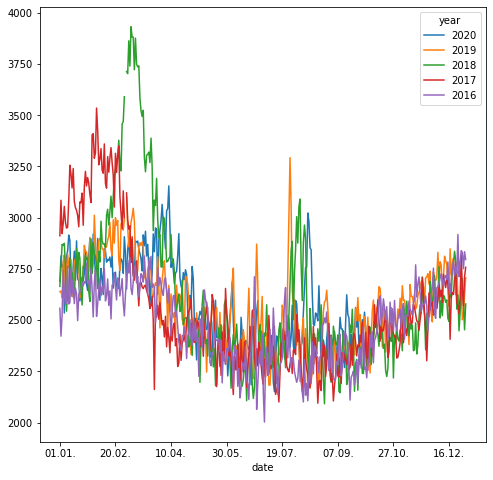

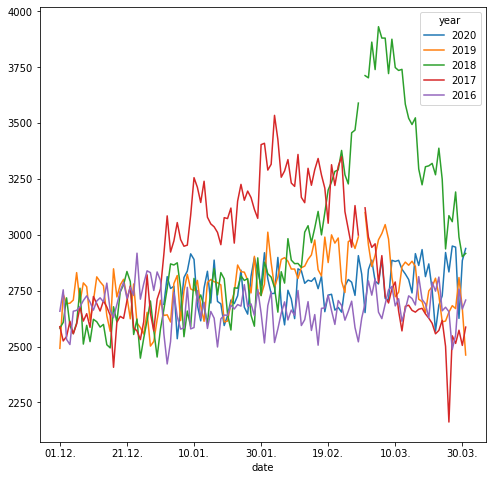

In [2]:
# Source: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.html
deaths = pd.read_excel("sonderauswertung-sterbefaelle-dstatis_20201031.xlsx",
                       sheet_name="D_2016_2020_Tage", na_values="X",
                       usecols=[0] + list(range(1, 367)), parse_dates=True, header=8, index_col=0)

deaths.index = deaths.index.map(lambda d: d.year)
deaths.index.name = 'year'
deaths.columns.name = 'date'
deaths = deaths.transpose()

deaths.plot(kind="line", figsize=(8, 8))

pd.concat([deaths.loc['01.12.':'31.12.', :],
           deaths.loc['01.01.':'31.03.', :]]).plot(kind="line", figsize=(8, 8))

deaths.index = deaths.index.map(
        lambda d: re.match(
            r'(?P<day>\d+)(?:\.)(?P<month>\d+)', d).groups()
    ).swaplevel()

deaths.index = deaths.index.map(lambda d: (int(d[0]), int(d[1])))
deaths.index.names = ['month', 'dayOfMonth']

# März 2018
Was war da los?
Die Sterbezahlen liegen deutlich über den anderen Jahren. Die Grippewelle soll außergewöhnlich schwer gewesen sein, insbesondere wegen nur bedingt wirksamem Impfstoff.

# Januar/Februar 2017
Ebenfalls ca. 10% über den anderen Jahren. Vermutlich ebenfalls Grippe.

# 2020
Sieht erstmal unauffällig aus. Ist aber auch zu erwarten, da pro Tag im Schnitt 2500 bis 2800 sterben und wir uns für mit Stand 30.10.2020 für 77 davon interessieren. Das ist der marginale Anteil von unter 3%.

# Korrelation der Sterblichkeit
Damit wir weniger von Tagesschwankungen abhängig sind, agregieren wir das einfach mal auf Monatsgenauigkeit zusammen. Und schauen mal ob es auffällige Abweichung zwischinden den Jahren gibt.

In [3]:
deathsByMonth = deaths.groupby(level=0).sum(min_count=28)

deathsByMonthCorr = deathsByMonth.corr()
deathsByMonthCorr.style.background_gradient('coolwarm', vmin=-1, vmax=1, axis='index')

year,2020,2019,2018,2017,2016
year,,,,,
2020,1.000000,0.848553,0.843126,0.678821,0.908884
2019,0.848553,1.000000,0.821395,0.820187,0.945886
2018,0.843126,0.821395,1.000000,0.594765,0.725318
2017,0.678821,0.820187,0.594765,1.000000,0.730656
2016,0.908884,0.945886,0.725318,0.730656,1.000000


- Generell zeigt die Korrellationsmatrix für 2020 noch keine großen Auffälligkeiten, denn wie erwähnt wir suchen 3%.
- 2017 und 2018 wirken sehr atypisch, wie oben schon beschrieben
    - Mehr samples könnten helfen das einzuordnen


# Vergleich mit dem Durchschnitt

<AxesSubplot:xlabel='month,dayOfMonth'>

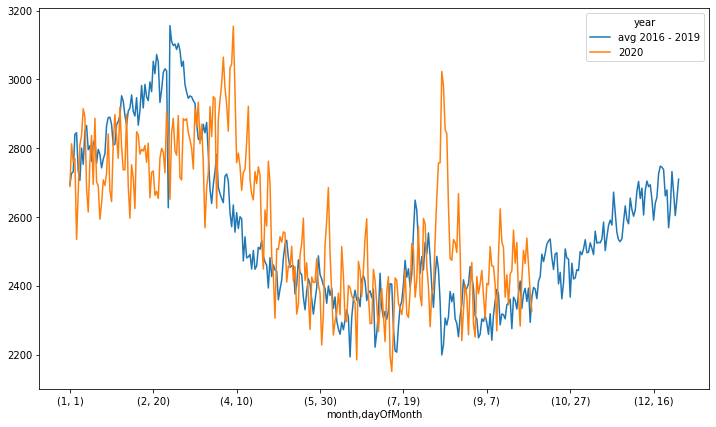

In [4]:
meanDeaths = deaths.copy()
#meanDeaths.index = meanDeaths.index.map(str)
meanDeaths['avg 2016 - 2019'] = meanDeaths.loc[:,'2019':'2016'].mean(axis='columns', skipna=True)

meanDeaths[['avg 2016 - 2019', 2020]].plot(kind="line", figsize=(12, 7))


- Seit etwa Anfang März liegt die Sterblichkeit über den Durschschnitt
- Nicht zu sehen sind etwa Auswirkungen eines Lockdowns
    - Hier wären eigentlich weniger Unfalltote zu erwarten, mglw. wurde das aber durch suizidale E-Bike-Fahrer ausgeglichen
    - Eine alternative Interpretation verfolgt die Argumentation der Corona-Leugner: "Den Lock-Down gibt es gar nicht"
- Für den starken Anstieg im August hab ich noch keine Erklärung (Hitzewelle?). Ggf. gibt es hier Parallelen zu 2018.

# Wenden wir uns mal Covid zu
Die Daten sind vim RKI und offensichtlich von einem Studenten mit begrenzten Excelkenntnissen gepflegt. Deswegen muss man den Scheiß auch nochmal reindexen.

In [5]:
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Fallzahlen_Kum_Tab.html
covidDeaths = pd.read_excel("covid-cases_rki_20201031.xlsx",
                            sheet_name='Fälle-Todesfälle-gesamt',
                            header=None, skiprows=3,
                            names=['date', 'covidCases', 'Covid Deaths 2020'],
                            usecols="A,D,F",
                            index_col=0, parse_dates=[0])

covidDeaths.index = pd.date_range(start='2020-02-25',
                                  periods=len(covidDeaths.index),
                                  freq='1D', name='date').map(lambda d: (d.month, d.day))

covidDeaths.index.names = ['month', 'dayOfMonth']

Hin und wieder scheint es auch zur wundersamen Wiederauferstehung zu kommen. Zombies sind bereits unter uns. So scheinen die Daten mehrere Korrekturen zu enthalten.

In [6]:
covidDeaths.describe()

,covidCases,Covid Deaths 2020
count,248.000000,236.000000
mean,2014.830645,43.851695
std,2787.808023,67.073152
min,5.000000,-7.000000
25%,474.250000,5.000000
50%,977.000000,12.000000
75%,2283.500000,47.000000
max,18681.000000,315.000000


In [7]:
covidDeaths[covidDeaths['Covid Deaths 2020'] < 0]

,,covidCases,Covid Deaths 2020
month,dayOfMonth,,
6,21,687.0,-1.0
8,2,240.0,-7.0


<AxesSubplot:xlabel='month,dayOfMonth'>

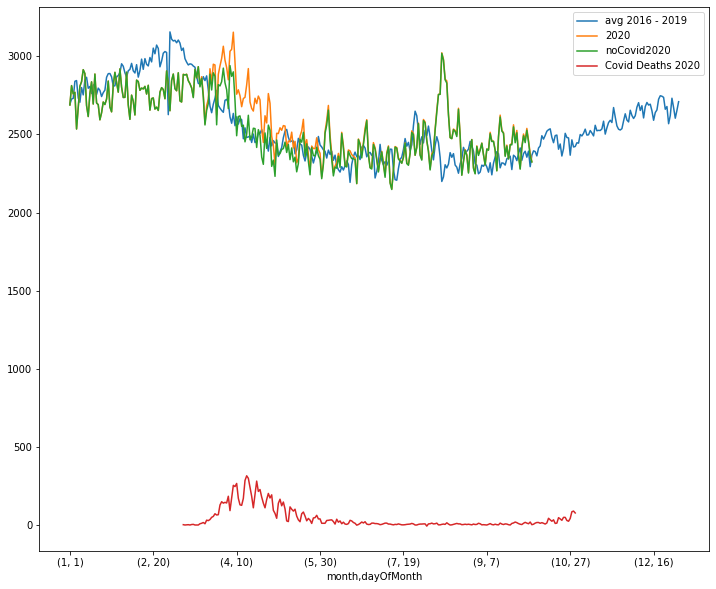

In [8]:
deathsWithCovid = meanDeaths.join(covidDeaths, how='outer', sort=False)
deathsWithCovid ['noCovid2020'] = deathsWithCovid[2020] - deathsWithCovid['Covid Deaths 2020'].fillna(0)
deathsWithCovid[['avg 2016 - 2019', 2020, 'noCovid2020', 'Covid Deaths 2020']].plot(kind="line",figsize=(12,10))

# Zoomen wir mal rein

<AxesSubplot:xlabel='month,dayOfMonth'>

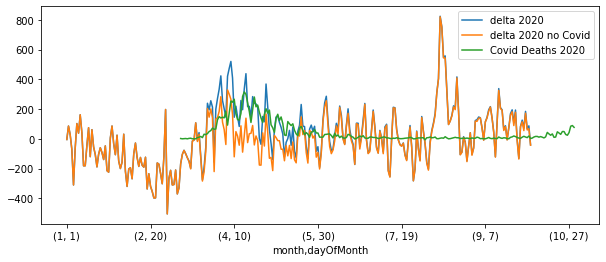

In [9]:
deathsWithCovid['delta 2020'] = deathsWithCovid[2020] - deathsWithCovid['avg 2016 - 2019']
deathsWithCovid['delta 2020 no Covid'] = deathsWithCovid['noCovid2020'] - deathsWithCovid['avg 2016 - 2019']

deathsWithCovid[['delta 2020', 'delta 2020 no Covid', 'Covid Deaths 2020']].plot(kind='line', figsize=(10, 4))

- Das Delta 2020 ist die Differenz zwischen den Todesfällen aus 2020 und dem Durchschnitt der Todesfälle aus 2016 bis 2019. 0 heißt in obigem Diagram also exakt durchschnittlich viele Todesfälle.
- "delta 2020 no Covid" sind die Sterbezahlen für 2020 nach Abzug der Covid-Todesfälle. Man Sieht, das liegt offensichtlich näher am Durchschnitt und insbesondere sieht man dass ein guter Teil des Anstiegs über den Durschschnitt im März auf Covid fällt. Die um Covid-19 bereinigten Zahlen bewegen sich ziemlich genau beim Durschnitt
- Die Zahlen aus dem März sind m.M.n. mit Vorsicht zu genießen, denn die Testhäufigkeit war niedrig und das Meldeverfahren im Anlauf. Es sind also durchaus höhere Dunkelziffern anzunehmen. Das legt auch der starke Anstieg von Februar bis April als Hypothese nahe.
- Der erste dokumentierte Covid-Fall in Deutschland stammt übrigens von Ende Januar, die Aufzeichnungen beginnen am 25. Februar.

In [10]:
deathsWithCovid[['delta 2020', 'delta 2020 no Covid', 'Covid Deaths 2020']].groupby('month').sum().corr().style.background_gradient('coolwarm',
                                                                                                                                vmin=-1, vmax=1,
                                                                                                                                axis="index")


,delta 2020,delta 2020 no Covid,Covid Deaths 2020
delta 2020,1.000000,0.873222,0.615803
delta 2020 no Covid,0.873222,1.000000,0.160029
Covid Deaths 2020,0.615803,0.160029,1.000000


Zum einen sieht man, das die Sterbezahlen von Nicht-Covid-Fällen dominiert sind, zum anderen sieht man aber auch, dass der Verlauf der Covid-Opferzahlen schon gut mit dem Verlauf der allgemeinen Sterbezahlen korreliert. Zumindest deutlich besser, als mit denen um Covid bereinigten Zahlen.